# Learn from linear data (plus noise)

Welcome to this notebook. This ntoebook is available at my GitHub http://ww.github.com/pauloabelha/notebooks

I made while delving deep into Machine Learning to understand things from first principles.
All code in here is of my own authorship.
Resources:
Wikipedia
David Mackay's bible was a valuable resource: http://www.inference.org.uk/mackay/itila/book.html
Another good book: http://www.gaussianprocess.org/gpml/
Yer another good book: http://www.deeplearningbook.org/

In this notebook we compare four different Machine Learning approaches for fitting a function to noisy linear data
- Linear Regression
- Bayesian Linear Regression
- Neural Networks
- Gaussian Processes


p.s.: One interestig thing would be to implement our own Gaussian distribution sampler:
    http://www.alanzucconi.com/2015/09/16/how-to-sample-from-a-gaussian-distribution/

First, we import everything and get a numpy fixed seed for reproducibility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# for reproducibility
random_seed_ix = 1
np.random.seed(random_seed_ix)

First we define our function for generating our data according to a linear model plus Gaussian noise

In [2]:
# X is originally a matrix of (n_pts,n_dis), but we encode the bias by adding a column of ones to it the linear model becomes just
# y = X*w isntead of y = X*w + b
# We also add the bias to the weight vector
def augment_with_bias(X,b,w):
    n_pts = X.shape[0]
    n_dims = X.shape[1]
    X_b = np.hstack((X,np.ones((n_pts,1))))
    w_b = np.append(w,np.full((1,1),b),axis=0)
    return X_b, w_b

In [3]:
# Decode data encoded by augment_with_bias to retrieve the original X, w matrices and the bias b
def disaugment_with_bias(X_b,w_b):
    X = X_b[:,:-1]
    b = w_b[-1,0]
    w = w_b[:-1,:]
    return X, w, b

In [4]:
# the linear model y = X*w + b using the encoded bias
def linear_model(X,w,b = 0,noise_sigma = 0):
    n_pts = X.shape[0]
    X_b, w_b = augment_with_bias(X,b,w)
    noise_vec = np.random.normal(0,noise_sigma,(n_pts,1))    
    y = np.dot(X_b,w_b) + noise_vec
    # ensure y is a (n_pts,1) vector
    assert(y.shape[0] == n_pts)
    assert(y.shape[1] == 1)
    return y, noise_vec, X_b, w_b

In [5]:
# Generate Gaussian-noisy linear data plus
# X is (n_pts,n_dims), where n is number of examples and d is numebr of dimensions
# the bias is included in X as an extra column
# so the vector w also gets an extra element (always 1)
# y is (n_pts,1)
# currently this code is for one dimension only
def gen_Gauss_noisy_lin_data(n_pts, random_seed_ix = 1, plot_fig = 0):  
    # number of dimensions
    n_dims = 1
    # for reproducibility
    np.random.seed(random_seed_ix)
    # noise level (variance of Gaussian distribution for noise)
    noise_sigma = np.random.rand(1)*0.1
    # get X as a random matrix (with one xtra column for adding bias)
    X = np.random.rand(n_pts,n_dims)
    # add the bias by overwriting the extra column of X
    b = np.random.randn()
    # ensure w has only positive values (for more intuitive visualisation from left to right)
    w = abs(np.random.randn(n_dims,1))
    # get y
    y, noise_vec, X_b, w_b = linear_model(X,w,b,noise_sigma)
    if plot_fig:
        plt.scatter(X, y)
        plt.show()
    return (X_b, y, w_b, noise_vec)

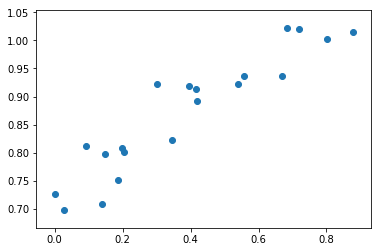

X_train shape (wth added bias) = (20, 2)
y_train shape = (20, 1)
w shape (with added bias) = (2, 1)
noise shape = (20, 1)


In [6]:
X_train_b, y_train, w_b, noise = gen_Gauss_noisy_lin_data(20,random_seed_ix,True)
print("X_train shape (wth added bias) = " + str(X_train_b.shape))
print("y_train shape = " + str(y_train.shape))
print("w shape (with added bias) = " + str(w_b.shape))
print("noise shape = " + str(noise.shape))

Now we perform Linear Regression

In [7]:
# mean squared error for our linear model
def my_mse(y_hat,y):
    m = y_hat.shape[1]
    mse = (1/m)*np.sum(np.power(y_hat-y,2))
    return mse    

In [8]:
# perform linear regression using mean squared error
# http://www.deeplearningbook.org/contents/ml.html (Section 5.1.4)
def linear_regression(X_train,y_train):
    assert(X_train.shape[0] == y_train.shape[0])
    a = np.linalg.inv(np.dot(X_train.T,X_train))
    b = np.dot(a,X_train.T)
    w_pred = np.dot(b,y_train)    
    y_pred = np.dot(X_train,w_pred)
    assert(y_pred.shape == y_train.shape)
    mse = my_mse(y_train,y_pred)
    return w_pred, y_pred, mse

Predicted w = [[ 0.3690886]]
Real w = [[ 0.37299379]]
Predicted b = 0.729975596414
Real b = 0.72886500896
Mean squared error = 0.0280327349634


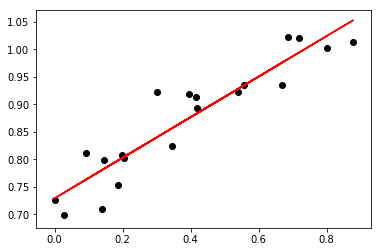

In [9]:
w_pred, y_pred, mse = linear_regression(X_train_b,y_train)
X_train, w, b = disaugment_with_bias(X_train_b,w_b)
print("Predicted w = " + str(w_pred[:-1,:]))
print("Real w = " + str(w))
print("Predicted b = " + str(b))
print("Real b = " + str(w_pred[1,0]))
print("Mean squared error = " + str(mse))

plt.plot(X_train,y_pred, color = 'r')
plt.scatter(X_train, y_train, color = 'k')
plt.show()

Now we plot the loss function to see the minimum

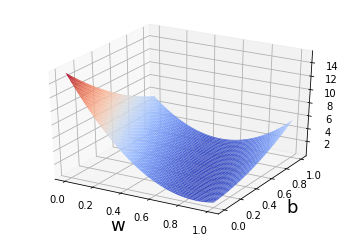

In [10]:
n_iter = 100
w_curr = np.zeros((1,1))
mse_errors = np.zeros((n_iter,n_iter))
for i in range(n_iter):
    w_curr[0,0] = i/n_iter
    for j in range(n_iter):
        b_curr = j/n_iter
        y_hat, _, _, _ = linear_model(X_train,w_curr,b_curr)
        mse_errors[i,j] = my_mse(y_hat,y_train)
x = np.linspace(0, 1, n_iter)
y = np.linspace(0, 1, n_iter)
xv, yv = np.meshgrid(x, y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, mse_errors, cmap=cm.coolwarm)
plt.xlabel('w', fontsize=18)
plt.ylabel('b', fontsize=18)
plt.show()